In [1]:
#%matplotlib notebook

In [2]:
from pathlib import Path

import matplotlib
import pymimir as mi
import networkx as nx
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import numpy as np

In [3]:
blocks_instance = "medium"
run_name = "12-08_11-54-41"

In [4]:
blocks_domain = mi.DomainParser("../test/pddl_instances/blocks/domain.pddl").parse()
blocks_problem = mi.ProblemParser(
    f"../test/pddl_instances/blocks/{blocks_instance}.pddl").parse(
    blocks_domain)
space = mi.StateSpace.new(blocks_problem, mi.GroundedSuccessorGenerator(blocks_problem))

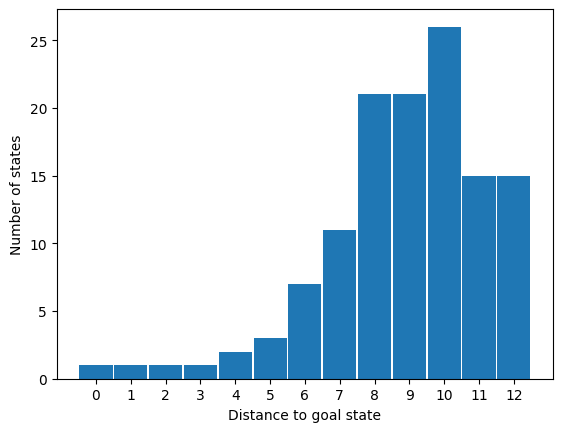

In [5]:
# Draw a histogram over the distances to the goal state
# Display the x-tick number below in the middle of the bars
distances = [space.get_distance_to_goal_state(s) for s in space.get_states()]
unique_distances = len(set(distances))
plt.xlabel("Distance to goal state")
plt.ylabel("Number of states")
plt.hist(distances, bins=np.arange(unique_distances + 1) - 0.5, rwidth=0.95)
plt.xticks(range(unique_distances))
plt.show()

In [6]:
(space.get_distance_to_goal_state(space.get_initial_state()),
 max(space.get_distance_to_goal_state(s) for s in space.get_states()))

(6, 12)

In [7]:
gamma = 0.9
non_goal_states = [s for s in space.get_states() if not space.is_goal_state(s)]
distances = torch.tensor(
    [space.get_distance_to_goal_state(s) for s in non_goal_states],
    dtype=torch.int,
)
optimal_values = -(1 - gamma ** distances) / (1 - gamma)

In [8]:
unique_optimal_values = optimal_values.unique()

In [9]:
-1 * (gamma ** torch.arange(0, 12)).sum()

tensor(-7.1757)

In [10]:
out_dir = Path(f"../out/{blocks_instance}/{run_name}/")

In [11]:
values = torch.load(out_dir / "values.pt")

# Investigate values

Values are the predictions for all non-goal states over each iteration.
Note that indices have to be shifted to adjust to the missing goa states.

We expect that the initial state starts with a highly negative value and converges to 0, as the actual distance will be greater than the initial prediction (of around 0.5).
Previously values are $\hat V(s) - V(s)$, prediction - optimal

In [12]:
sqavg_values = (values - optimal_values).square()
l1_values = torch.abs(values - optimal_values)

In [13]:
(total_iterations := len(values))

2000

In [14]:
(initial_state_idx := space.get_states().index(space.get_initial_state()))

0

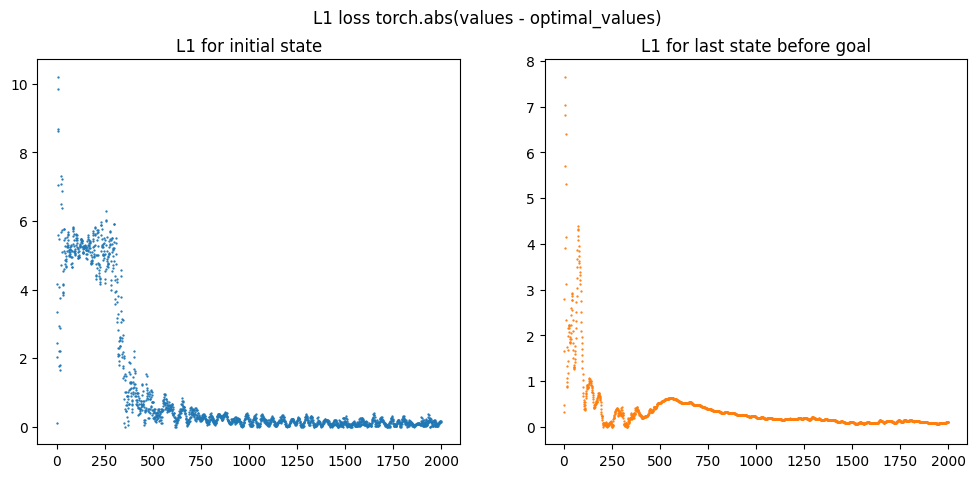

In [15]:
# plot values for initial state over all time steps
one_before_goal = next(i for i, s in enumerate(space.get_states()) if
                       space.get_distance_to_goal_state(s) == 1)


def visz_l1_loss_for_states():
    fig, (ax_init, ax_one_before) = plt.subplots(1, 2, figsize=(12, 5))

    start_it = 0
    ax_init.scatter(torch.arange(start_it, total_iterations),
                    l1_values[start_it:, initial_state_idx], s=0.4)
    ax_init.set_title("L1 for initial state")

    start_it = 0
    ax_one_before.scatter(torch.arange(start_it, total_iterations),
                          l1_values[start_it:, one_before_goal], s=0.4, c='tab:orange')
    ax_one_before.set_title("L1 for last state before goal")

    fig.suptitle("L1 loss torch.abs(values - optimal_values)")
    plt.show()


visz_l1_loss_for_states()

In [16]:
values[-1][one_before_goal]

tensor(-1.1023)

In [17]:
mse_loss = torch.mean(sqavg_values, dim=1)

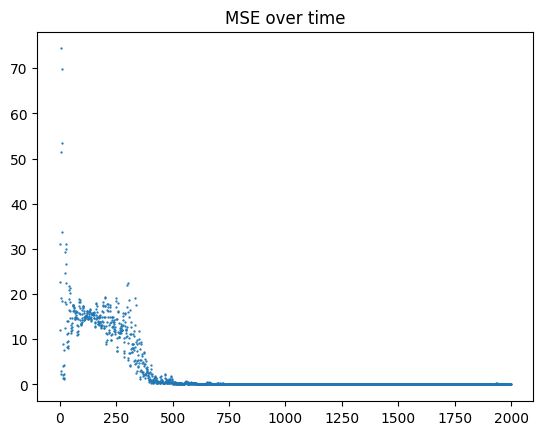

In [18]:
plt.scatter(torch.arange(0, total_iterations), mse_loss, s=0.4)
plt.title("MSE over time")
plt.show()

In [19]:
torch.mean(sqavg_values[-1]), torch.std(sqavg_values[-1]), torch.max(sqavg_values[-1])

(tensor(0.0149), tensor(0.0134), tensor(0.0948))

## Visualize the loss components over time

In [20]:
loss_files = out_dir.glob("loss_*")
losses = {file.stem: torch.load(file) for file in loss_files}

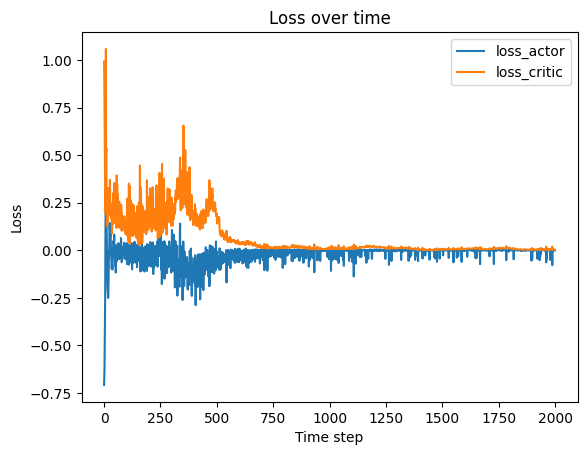

In [21]:
fig, ax = plt.subplots()
ax.set_title("Loss over time")
ax.set_xlabel("Time step")
ax.set_ylabel("Loss")
for name, loss in losses.items():
    ax.plot(torch.arange(len(loss)), loss, label=name)
plt.legend(loc="upper right")
plt.show()

In [22]:
def visz_epsilon(epsilon_file_name="epsilon.pt"):
    if not (out_dir / epsilon_file_name).exists():
        return
    epsilon_steps: torch.Tensor = torch.load(out_dir / "epsilon.pt")
    update_epsilon_per_step = (0.2 - 0.01) / int(1 * total_iterations)
    epsilon_per_iteration_step = epsilon_steps.count_nonzero(dim=1).view(-1)
    # visualize the number of random steps over time as bar chart
    plt.bar(torch.arange(0, total_iterations), epsilon_per_iteration_step)
    #plt.bar(range(total_iterations), [epsilon_over_time[i]*124 for i in range(total_iterations)], alpha=0.5)
    plt.title("Number of random steps over time")
    plt.show()


visz_epsilon()

### Done samples are the number of goal states encountered over time

In [23]:
done_samples = torch.load(out_dir / "done_samples.pt")
accumulated_done_samples = torch.tensor(done_samples, dtype=torch.int).cumsum(dim=0)

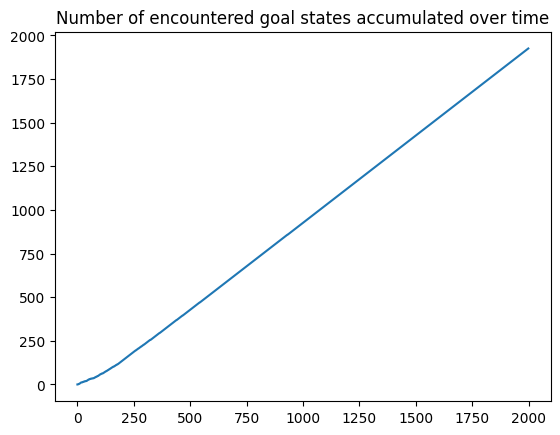

In [24]:
plt.plot(range(total_iterations), accumulated_done_samples)
plt.title("Number of encountered goal states accumulated over time")
plt.show()

### Actions selected over time

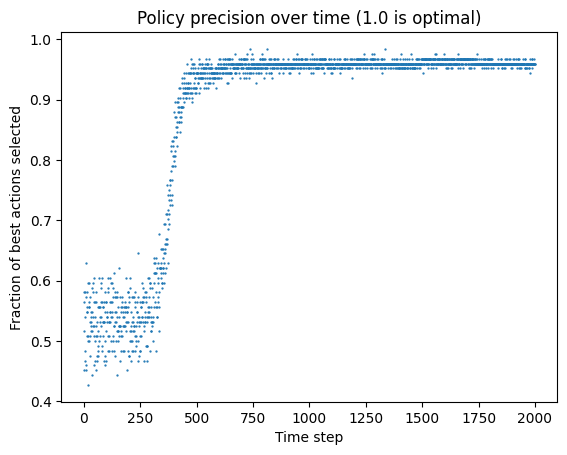

In [25]:
def visz_policy_precision_over_time():
    if not (out_dir / "actions.pt").exists():
        return

    action_indices: list[list[int]] = torch.load(out_dir / "actions.pt")
    non_goal_transitions = [space.get_forward_transitions(s) for s in non_goal_states]

    # Get the index of the best action for every non-goal state

    def idx_of_best_transition(transitions) -> int:
        return min(range(len(transitions)),
                   key=lambda i: space.get_distance_to_goal_state(
                       transitions[i].target))

    idx_of_best = [idx_of_best_transition(transitions)
                   for transitions in non_goal_transitions]

    def number_of_optimal_actions(timestep):
        return sum(
            selected_action_idx == best_action_idx
            for selected_action_idx, best_action_idx in
            zip(action_indices[timestep], idx_of_best))

    num_selected_best_action = [number_of_optimal_actions(time)
                                for time in range(total_iterations)
                                ]
    fraction_best_action = [num_opt_actions / len(non_goal_states)
                            for num_opt_actions in num_selected_best_action]

    fig, ax = plt.subplots()
    ax.scatter(range(total_iterations), fraction_best_action, s=0.4)
    ax.set_title("Policy precision over time (1.0 is optimal)")
    ax.set_xlabel("Time step")
    ax.set_ylabel("Fraction of best actions selected")
    plt.show()


visz_policy_precision_over_time()

# Visualize the state space over time

In [26]:
def construct_graph():
    graph = nx.DiGraph()
    goal_indices = set()
    for idx, state in enumerate(space.get_states()):
        if space.is_goal_state(state):
            goal_indices.add(idx)
        graph.add_node(state.__repr__(), idx=idx)
    for state in space.get_states():
        for t in space.get_forward_transitions(state):
            graph.add_edge(
                t.source.__repr__(), t.target.__repr__(), action=t.action.schema.name
            )
    return graph, goal_indices
graph, goal_indices = construct_graph()

In [27]:
def get_value_at(tensor, index):
    if index in goal_indices:
        return 0.0
    if index == 124:
        return tensor[index - 1].item()
    return tensor[index].item()


In [28]:
pos = nx.spring_layout(graph, seed=42, iterations=2000)

In [29]:
from matplotlib.animation import FuncAnimation


#sm.set_array([])
def update_graph_plot(time, scaled_cmap, axis, value_tensor):
    axis.clear()
    # Normalize the values
    # Map node colors
    node_colors = [
        scaled_cmap.to_rgba(get_value_at(value_tensor[time], attr["idx"]))
        for _, attr in
        graph.nodes.data()]

    # Draw the graph
    nx.draw_networkx(graph,
                     pos,
                     node_color=node_colors,
                     nodelist=[n for n in graph.nodes],
                     with_labels=False,
                     node_size=100,
                     arrowstyle="-",  # no arrows
                     ax=axis)

    axis.text(0.95, 0.95, f'Time step: {time}', horizontalalignment='right',
              verticalalignment='top', transform=axis.transAxes, fontsize=12,
              bbox=dict(facecolor='white', alpha=0.5))

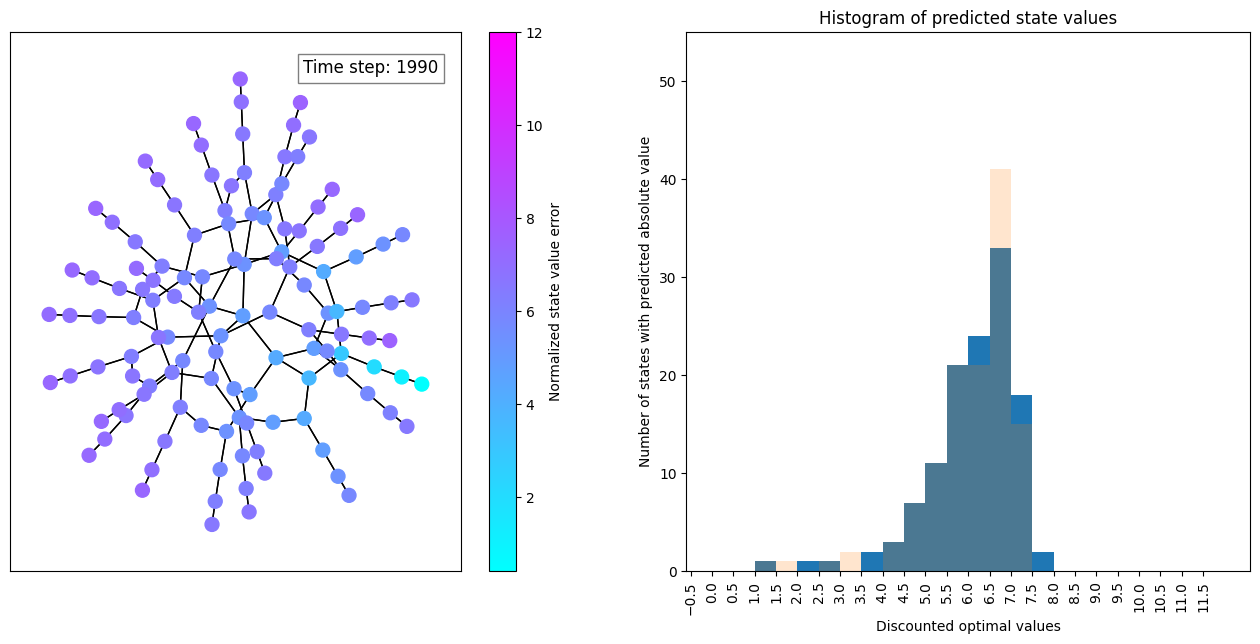

In [31]:
def plot_histogram(iteration, axis, bins,value_tensor):
    axis.clear()
    axis.hist(value_tensor[iteration], bins=bins)
    axis.hist(optimal_values.abs(), bins=bins, alpha=0.2, color='tab:orange')
    axis.set_title("Histogram of predicted state values")
    axis.set_xticks(bins - 0.5)
    axis.tick_params(axis='x', labelrotation=90)
    axis.set_xlabel("Discounted optimal values")
    axis.set_ylabel("Number of states with predicted absolute value")
    axis.set_ylim(bottom=0, top=55)

def plot_predicted_values():
    fig, (value_axis, hist_axis) = plt.subplots(figsize=(16, 7), ncols=2)
    max_value = 12
    clamped_abs_values = torch.clamp(values.abs(), max=max_value)
    
    cmap = plt.cm.cool
    vmin = clamped_abs_values.min().item()
    vmax = clamped_abs_values.max().item()
    normalized_cmap = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    
    sm = matplotlib.cm.ScalarMappable(norm=normalized_cmap, cmap=cmap)
    
    fig.colorbar(sm, ax=value_axis, orientation="vertical",
                 label="Normalized state value error")
    
    bins = torch.arange(0, max_value + 0.5, 0.5)
    
    
    def animate_values_and_hist(time):
        update_graph_plot(time, scaled_cmap=sm, axis=value_axis, value_tensor=clamped_abs_values)
        plot_histogram(time, hist_axis, bins,value_tensor=clamped_abs_values)
    
    
    ani = FuncAnimation(fig, animate_values_and_hist, frames=range(0, total_iterations, 10),
                        repeat=False)
    
    ani.save(out_dir / 'graph_values_with_hist.mp4', writer=FFMpegWriter(fps=6))
plot_predicted_values()


## Visualize the policy decisions over time

In [61]:
probs_list_of_nested = torch.load(out_dir / "probs.pt")

In [33]:
# Compute the entropy for each decision
# we normalize such that the entropy is in [0,1]
def entropy(tensor):
    return torch.distributions.Categorical(probs=tensor).entropy() / np.log(len(tensor))


entropy(torch.tensor([0.25, 0.25, 0.25, 0.25])), entropy(
    torch.tensor([1., 0.0, 0., 0.]))

(tensor(1.), tensor(8.5991e-08))

In [34]:
def visz_policy_certainty():
    plt.scatter(range(total_iterations),
                [entropy(probs_at_t[one_before_goal]) for probs_at_t in probs_list_of_nested],
                s=0.4)
    plt.scatter(range(total_iterations),
                [entropy(probs_at_t[initial_state_idx]) for probs_at_t in probs_list_of_nested],
                s=0.4,c='tab:orange')
    plt.title("Certainty of policy (0 is 100% certain, 1 is uniform distribution)")
    plt.xlabel("Time step")
    plt.ylabel("Entropy")
    plt.show()

In [71]:
edge_list[-2], space.get_forward_transitions(space.get_goal_states()[0])[0]

(("<State '1219916959908464036'>", "<State '12868838900105126958'>"),
 "<Transition 'unstack(d, c)'>")

In [69]:
edge_list[len(edge_list) - 2]

("<State '1219916959908464036'>", "<State '12868838900105126958'>")

In [35]:
from matplotlib.animation import FuncAnimation

from typing import List, Tuple
import itertools

edge_list: List[List[Tuple[str, str]]] = [
    [
        (t.source.__repr__(), t.target.__repr__()) for t in
        space.get_forward_transitions(s)
    ] for s in non_goal_states  # Watch out goal has edges too which are not in probs_list
]
edge_list = list(itertools.chain.from_iterable(edge_list))

def serialize_trans_prob(edges):
    return [(edge[0].__repr__(), edge[1].__repr__()) for edge in edges]

#sm.set_array([])
def update_edge_plot(time, axis):
    axis.clear()
    # Normalize the values
    # Map node colors
    probs_list = [[tensor.item() for tensor in trans_prob] for trans_prob in
                  probs_list_of_nested[time]]
    probs_list = list(itertools.chain.from_iterable(probs_list))

    # Draw the graph
    nx.draw_networkx_edges(graph, pos, ax=axis, node_size=100,
                           edgelist=edge_list,
                           alpha=probs_list,
                           connectionstyle="arc3,rad=0.2")

    nx.draw_networkx_nodes(graph, pos, ax=axis,
                           node_size=90, node_color="none",
                           linewidths=0.3, edgecolors="black")

    axis.text(0.95, 0.95, f'Time step: {time}', horizontalalignment='right',
              verticalalignment='top', transform=axis.transAxes, fontsize=12,
              bbox=dict(facecolor='white', alpha=0.5))

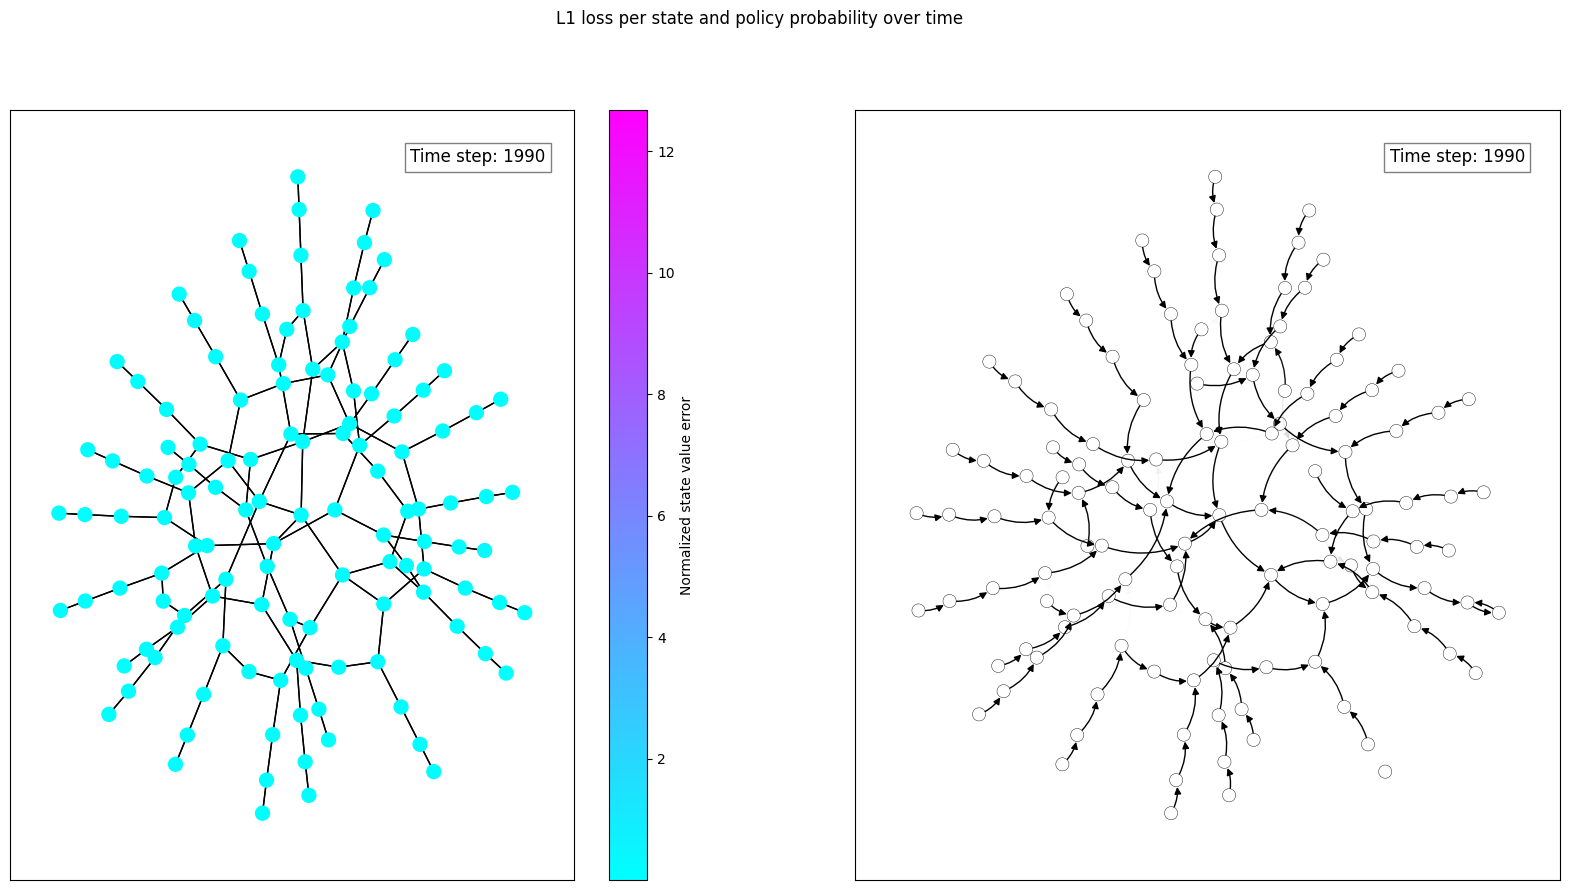

In [36]:
def update_nodes_and_edges(time, scaled_cmap, node_axis, edge_axis):
    update_graph_plot(time, scaled_cmap=scaled_cmap, axis=node_axis, value_tensor=l1_values)
    update_edge_plot(time, edge_axis)

def plot_l1_and_probs():
    fig, (ax_graph, ax_edges) = plt.subplots(figsize=(20, 10), ncols=2)
    
    fig.suptitle("L1 loss per state and policy probability over time")
    
    cmap = plt.cm.cool
    vmin = l1_values.min().item()
    vmax = l1_values.max().item()
    normalized_cmap = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    
    sm = matplotlib.cm.ScalarMappable(norm=normalized_cmap, cmap=cmap)
    
    
    fig.colorbar(sm, ax=ax_graph, orientation="vertical",
                 label="Normalized state value error")
    # Create the animation
    ani = FuncAnimation(fig, lambda time: update_nodes_and_edges(time, sm, ax_graph, ax_edges),
                        frames=range(0, len(values), 10), repeat=False)
    # Save the animation as a GIF
    ani.save(out_dir / "graph_with_probs.mp4", writer=FFMpegWriter(fps=6))
plot_l1_and_probs()

## Investigate the gradients

In [ ]:
gradients = dict()
gradients_dir = out_dir / "gradients"
for file in gradients_dir.iterdir():
    name = file.stem
    gradients[name] = torch.load(file)

In [ ]:
gradients.keys()

In [ ]:
# plot the gradients over time
gradient_name = "module.actor_net.1.lins.1.weight"
fig, ax = plt.subplots()
ax.set_title("Gradients over time")
ax.set_xlabel("Time step")
ax.set_ylabel("Gradient")
ax.plot(torch.arange(0, len(gradients[gradient_name])),
        gradients[gradient_name].squeeze())
plt.show()

In [ ]:
losses['loss_critic'].argmin()

In [ ]:
losses['loss_critic'][150]

In [ ]:
gradient_name = "module.value_operator.module.weight"
state_index = 99
fig, ax = plt.subplots()
ax.set_title(f"Gradients over time for weight: {state_index}")
ax.set_xlabel("Time step")
ax.set_ylabel("Gradient")
ax.scatter(torch.arange(0, len(gradients[gradient_name])),
           gradients[gradient_name].squeeze()[:, state_index], s=0.4)
plt.show()